In [1]:
def sort_by_target(mnist):
    reorder_train = np.array(sorted([(target, i) for i, target in enumerate(mnist.target[:60000])]))[:, 1]
    reorder_test = np.array(sorted([(target, i) for i, target in enumerate(mnist.target[60000:])]))[:, 1]
    mnist.data[:60000] = mnist.data[reorder_train]
    mnist.target[:60000] = mnist.target[reorder_train]
    mnist.data[60000:] = mnist.data[reorder_test + 60000]
    mnist.target[60000:] = mnist.target[reorder_test + 60000]
    
from sklearn.datasets import fetch_openml
import numpy as np

mnist = fetch_openml('mnist_784', version = 1, cache = True)
mnist.target = mnist.target.astype(np.int8) #Changes strings into int
sort_by_target(mnist) #To get sorted version as in book


In [2]:
X, y = mnist["data"], mnist["target"]
print(X.shape)
print(y.shape)

(70000, 784)
(70000,)


In [3]:
some_digit = X[36014]

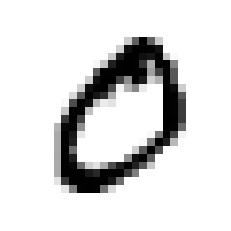

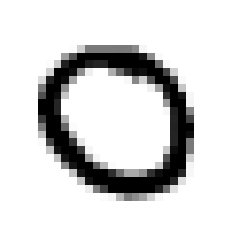

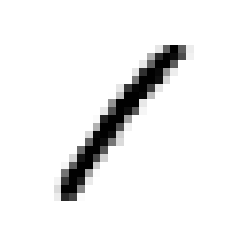

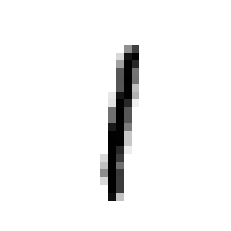

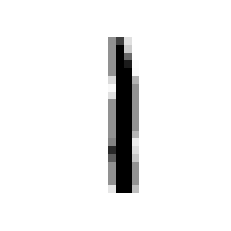

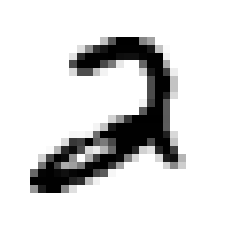

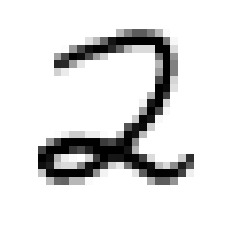

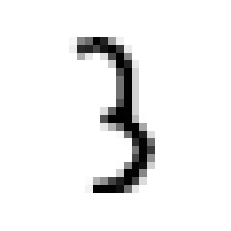

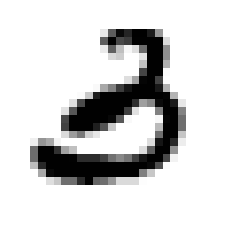

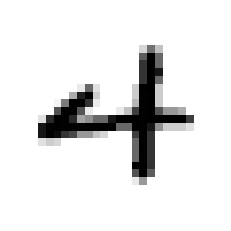

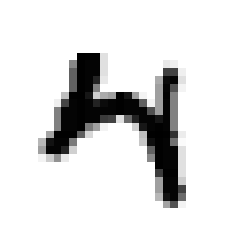

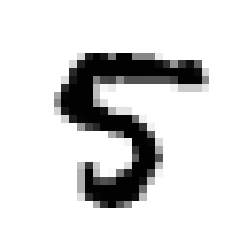

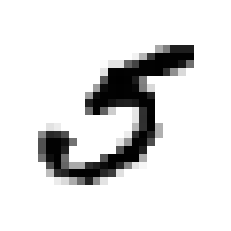

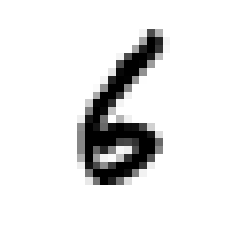

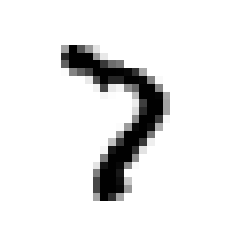

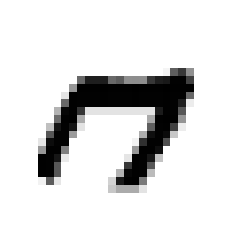

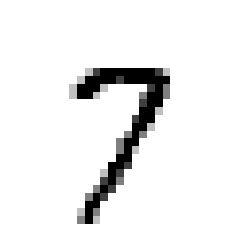

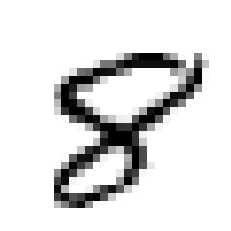

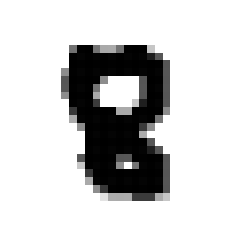

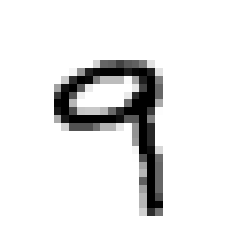

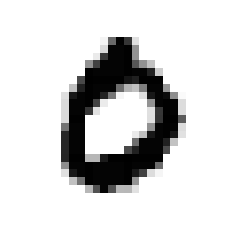

In [4]:
#Lets print out and see some of the images

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

some_digits = []
for i in range(0,60001,3000):
    some_digits.append(X[i])

for i in some_digits:
    plt.imshow(i.reshape(28,28), cmap = matplotlib.cm.binary, interpolation = "nearest")
    plt.axis("off")
    plt.show()


In [5]:
#MNIST is already sorted into training and test set. First 60000 is training set, remaining 10000 is test set

X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

#Lets shuffle training set so cross-validation folds will be similar and contain similar composition of digits

shuffle_index = np.random.permutation(60000)

X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

In [6]:
#Lets train a binary classifier, one that identifies a 5 or not

y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

#We will use the stochastic gradient descent classifier
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(max_iter=5, tol=-np.infty, random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=5,
              n_iter_no_change=5, n_jobs=None, penalty='l2', power_t=0.5,
              random_state=42, shuffle=True, tol=-inf, validation_fraction=0.1,
              verbose=0, warm_start=False)

In [7]:
sgd_clf.predict(some_digits)

array([False, False, False, False, False, False, False, False, False,
       False, False,  True, False, False, False, False, False, False,
       False, False, False])

In [8]:
# Implementing cross validation
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring = "accuracy")

#This gives over 95% accuracy, but this is not true. This is why accuracy is not usually a good 
# performance measure for classifiers (especially on skewed data-sets)

array([0.95685, 0.9696 , 0.96355])

In [9]:
# Implementing custom cross validation without using cross_val_score

from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits = 3, random_state = 42, shuffle = True)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_folds = X_train[test_index]
    y_test_folds = y_train_5[test_index]
    
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_folds)
    n_correct = sum(y_pred == y_test_folds)
    print (n_correct / len(y_pred))

0.9639
0.96695
0.9645


In [10]:
#Using cross_val_predict to get predictions on each fold. Clean predictions as predictions made by model 
# that hasnt seen the data during training

from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv = 3)

In [11]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_pred)

array([[54209,   370],
       [ 1830,  3591]], dtype=int64)

In [12]:
from sklearn.metrics import precision_score, recall_score, f1_score

print("Precision: " , precision_score(y_train_5, y_train_pred))
print("Recall: " , recall_score(y_train_5, y_train_pred))
print("f1 Score: " , f1_score(y_train_5, y_train_pred))

#Only 78% when claming an image is a 5
#Only detects 79% of the 5s

Precision:  0.9065892451401162
Recall:  0.6624239070282236
f1 Score:  0.7655084203794502


In [13]:
#Lets play around with the decision threshold

y_scores = sgd_clf.decision_function([some_digit])
y_scores

#Setting threshold to 0
threshold = 0
y_some_digit_pred = (y_scores>threshold)
print("Threshold 0: ", y_some_digit_pred)

#Setting threshold to 200000
threshold = 200000
y_some_digit_pred = (y_scores>threshold)
print("Threshold 200000: ", y_some_digit_pred)

#This shows raising the threshold decresases recall

Threshold 0:  [ True]
Threshold 200000:  [False]


In [14]:
#Now we try and find what is the optimum threshold to use

y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv = 3, method = "decision_function")

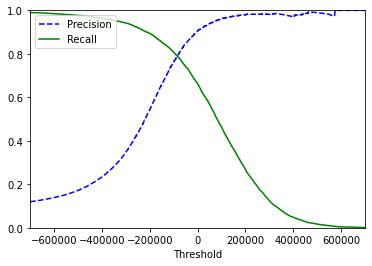

In [15]:
#Precision-Recall Curve

from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.xlabel("Threshold")
    plt.legend(loc="upper left")
    plt.ylim([0, 1])
    
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.xlim([-700000,700000])
plt.show()

#Precision curve is bumpier than the recall curve as precision might sometimes go down when threshold increases, but 
# recall will always go down when threshold increases. Therefore it is smoother

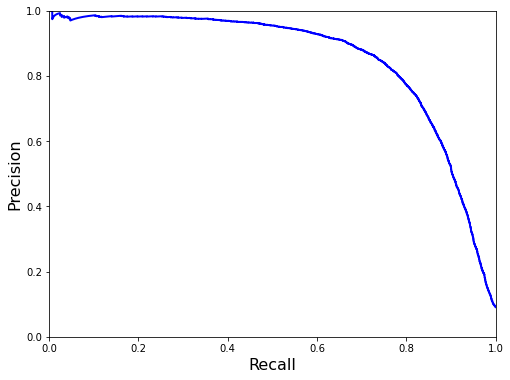

In [16]:
#Precision vs Recall Curve

def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])
    
plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
plt.show()

In [17]:
#Lets say we want 90% precision, looking at the first graph we need a threshold of about 70000

y_train_pred_90 = (y_scores>70000)

print("Precision: ", precision_score(y_train_5, y_train_pred_90))
print("Recall: ", recall_score(y_train_5, y_train_pred_90))

#You get around 90% Precision but recall is now low

Precision:  0.9484193011647255
Recall:  0.5257332595462092


Area under Curve:  0.9610574557828758


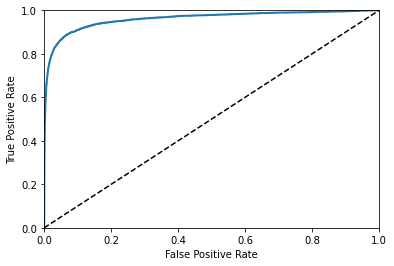

In [18]:
#ROC Curve and Area Under the curve (AUC)

from sklearn.metrics import roc_curve, roc_auc_score

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

def plot_roc_curve(fpr, tpr, label = None):
    plt.plot(fpr, tpr, linewidth = 2, label = label)
    plt.plot([0,1], [0,1], "k--")
    plt.axis([0,1,0,1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    
plot_roc_curve(fpr, tpr)
plt.show

print("Area under Curve: ", roc_auc_score(y_train_5, y_scores))

In [19]:
#Lets use a RandomForest Classifier and compare ROC Curves

from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state = 42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method="predict_proba")

y_scores_forest = y_probas_forest[:, 1] #Score = Proba of Positive class i.e First Column

fpr_forest, tpr_forest, thresh_forest = roc_curve(y_train_5, y_scores_forest)

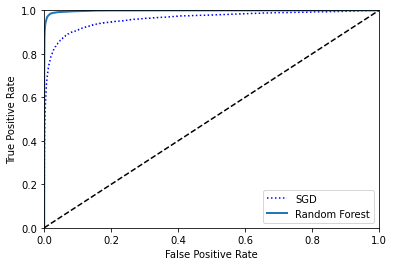

SGD AUC:  0.9610574557828758
RandomForest AUC:  0.9983499055416589


In [20]:
#Plot the ROC Curves together and compare

plt.plot(fpr, tpr, "b:", label = "SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc = "lower right")
plt.show()

print("SGD AUC: ", roc_auc_score(y_train_5, y_scores))
print("RandomForest AUC: ", roc_auc_score(y_train_5, y_scores_forest))

#Random Forest AUC is really good, and if you check precision and recall, it is really good as well. Promising model

In [21]:
#Multiclass Classification
#Sklearn automatically detects when you try use a binary classification algorithm on a multiclass task
#It then automatically runs OvA (OvO for SVMs)

sgd_clf.fit(X_train, y_train)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=5,
              n_iter_no_change=5, n_jobs=None, penalty='l2', power_t=0.5,
              random_state=42, shuffle=True, tol=-inf, validation_fraction=0.1,
              verbose=0, warm_start=False)

In [22]:
print(sgd_clf.predict([some_digit]))
some_digit_scores = sgd_clf.decision_function([some_digit])
print(some_digit_scores)

#You can see all the scores from each class, and indeed 5 has the highest score and therefore this class is picked

#To view the classes
print(sgd_clf.classes_)

[5]
[[-307045.29798805 -321295.1259632  -176435.60689033 -302261.33354659
  -116466.38394118  302123.05031994 -112513.21223549 -403272.51771239
  -323788.5823618  -303569.30491237]]
[0 1 2 3 4 5 6 7 8 9]


In [23]:
#To force Sklearn to use a specific mechanism use OneVsOneClassifier or OneVsRestClassifier

from sklearn.multiclass import OneVsOneClassifier

ovo_clf = OneVsOneClassifier(SGDClassifier(random_state = 42))
ovo_clf.fit(X_train, y_train)

OneVsOneClassifier(estimator=SGDClassifier(alpha=0.0001, average=False,
                                           class_weight=None,
                                           early_stopping=False, epsilon=0.1,
                                           eta0=0.0, fit_intercept=True,
                                           l1_ratio=0.15,
                                           learning_rate='optimal',
                                           loss='hinge', max_iter=1000,
                                           n_iter_no_change=5, n_jobs=None,
                                           penalty='l2', power_t=0.5,
                                           random_state=42, shuffle=True,
                                           tol=0.001, validation_fraction=0.1,
                                           verbose=0, warm_start=False),
                   n_jobs=None)

In [24]:
print(ovo_clf.predict([some_digit]))
print(len(ovo_clf.estimators_)) #n*(n-1)/2 Therefore 45 different One on one battles

[5]
45


In [25]:
#Training a Random Forest Classifier is easy as it already can deal with multiclass

forest_clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [26]:
print(forest_clf.predict_proba([some_digit]))

#As you can see the class for 5 has the highest probability of 0.92

print(forest_clf.predict([some_digit]))

[[0.02 0.   0.   0.   0.01 0.97 0.   0.   0.   0.  ]]
[5]


In [27]:
#Lets evaluate the classifiers

sgd_eval = cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")
forest_eval = cross_val_score(forest_clf, X_train, y_train, cv=3, scoring="accuracy")

print("SGD Evaluation: ", sgd_eval)
print("RandomForest Evaluation: " , forest_eval)

SGD Evaluation:  [0.8723  0.86045 0.86475]
RandomForest Evaluation:  [0.96455 0.96835 0.9639 ]


In [28]:
#Lets scale the input then re-evaluate

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))

In [29]:
sgd_eval = cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")
forest_eval = cross_val_score(forest_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

print("SGD Evaluation after Scaling: ", sgd_eval)
print("RandomForest Evaluation after Scaling: " , forest_eval)

#Scaling increases SGD evaluation to 90%

SGD Evaluation after Scaling:  [0.9101 0.9108 0.9062]
RandomForest Evaluation after Scaling:  [0.9646  0.96855 0.96395]


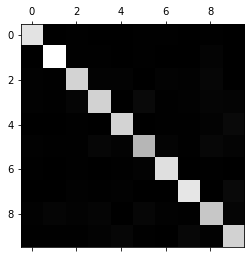

In [30]:
#Error Analysis

y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv = 3)
conf_mx = confusion_matrix(y_train, y_train_pred)
plt.matshow(conf_mx, cmap = plt.cm.gray)
plt.show()

<function matplotlib.pyplot.show(*args, **kw)>

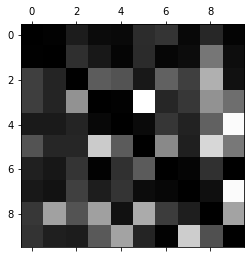

In [31]:
row_sums = conf_mx.sum(axis=1, keepdims = True)
norm_conf_mx = conf_mx / row_sums

np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show

#Looking at this we can see 8 and 9 columns are quite bright which shows that most images are incorrectly classified as 8 or 9
#8 and 9 rows are also quite bright showing 8s and 9s are incorrectly classified as other digits
#3 and 5 intersections are quite bright showing these are often confused, lets investigate this

In [39]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = matplotlib.cm.binary,
               interpolation="nearest")
    plt.axis("off")

def plot_digits(instances, images_per_row=10, title = "",**options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = matplotlib.cm.binary, **options)
    plt.title(title)
    plt.axis("off")

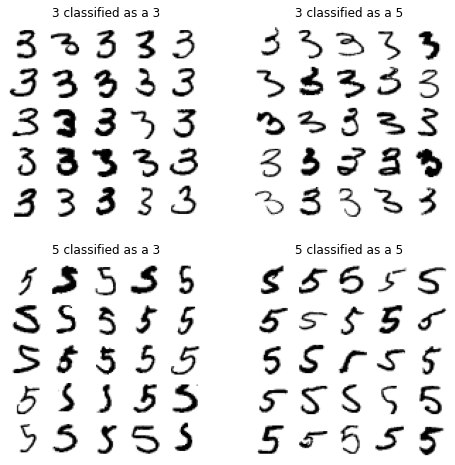

In [33]:
#Investigating 3 and 5 confusion 

X_33 = X_train[(y_train == 3) & (y_train_pred == 3) ] #3 classified as 3
X_35 = X_train[(y_train == 3) & (y_train_pred == 5) ] #3 classified as 5
X_53 = X_train[(y_train == 5) & (y_train_pred == 3) ] #5 classified as 3
X_55 = X_train[(y_train == 5) & (y_train_pred == 5) ] #5 classified as 5

plt.figure(figsize = (8,8))
plt.subplot(221); plot_digits(X_33[:25], images_per_row=5, title = "3 classified as a 3")
plt.subplot(222); plot_digits(X_35[:25], images_per_row=5, title = "3 classified as a 5")
plt.subplot(223); plot_digits(X_53[:25], images_per_row=5, title = "5 classified as a 3")
plt.subplot(224); plot_digits(X_55[:25], images_per_row=5, title = "5 classified as a 5")
plt.show()

In [34]:
#Multilabel Classification

from sklearn.neighbors import KNeighborsClassifier #Can handle Multilabel Classification

y_train_GTEQ_7 = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)

y_multilabel = np.c_[y_train_GTEQ_7, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

#Lets see a result
knn_clf.predict([some_digit])

#Predicts correctly that 5 is < 7 and is odd

array([[False,  True]])

In [35]:
#Evaluating a Multilabel Classification System
#This cell has been commented out as it takes a very long time to run

#y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
#f1_score(y_multilabel, y_train_knn_pred, average = "macro")

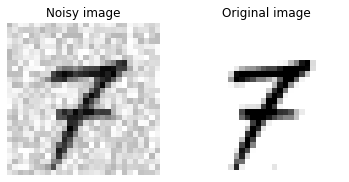

In [40]:
#Multioutput Classification
#We build a system that removes noise from images
#The Instances will be the noisy images and the labels will be the original untouched images

noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
y_train_mod = X_train

#Lets see an image
plt.subplot(121, title = "Noisy image"); plot_digit(X_train_mod[5500])
plt.subplot(122, title = "Original image"); plot_digit(y_train_mod[5500])

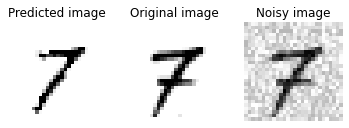

In [43]:
#Training the multioutput classifier

knn_clf.fit(X_train_mod, y_train_mod)

pred_digit = knn_clf.predict([X_train_mod[5500]])

plt.subplot(131, title = "Predicted image"); plot_digit(pred_digit)
plt.subplot(132, title = "Original image"); plot_digit(y_train_mod[5500])
plt.subplot(133, title = "Noisy image"); plot_digit(X_train_mod[5500])